In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools

# Data preparation

### Load the Data Set

In [7]:
crime_df = pd.read_csv('Crime_Data_from_2020_to_Present.csv')
crime_df.head()

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,190326475,03/01/2020 12:00:00 AM,03/01/2020 12:00:00 AM,2130,7,Wilshire,784,1,510,VEHICLE - STOLEN,...,AA,Adult Arrest,510.0,998.0,NaN,NaN,1900 S LONGWOOD AV,NaN,34.0375,-118.3506
1,200106753,02/09/2020 12:00:00 AM,02/08/2020 12:00:00 AM,1800,1,Central,182,1,330,BURGLARY FROM VEHICLE,...,IC,Invest Cont,330.0,998.0,NaN,NaN,1000 S FLOWER ST,NaN,34.0444,-118.2628
2,200320258,11/11/2020 12:00:00 AM,11/04/2020 12:00:00 AM,1700,3,Southwest,356,1,480,BIKE - STOLEN,...,IC,Invest Cont,480.0,NaN,NaN,NaN,1400 W 37TH ST,NaN,34.0210,-118.3002
3,200907217,05/10/2023 12:00:00 AM,03/10/2020 12:00:00 AM,2037,9,Van Nuys,964,1,343,SHOPLIFTING-GRAND THEFT ($950.01 & OVER),...,IC,Invest Cont,343.0,NaN,NaN,NaN,14000 RIVERSIDE DR,NaN,34.1576,-118.4387
4,200412582,09/09/2020 12:00:00 AM,09/09/2020 12:00:00 AM,630,4,Hollenbeck,413,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,200 E AVENUE 28,NaN,34.0820,-118.2130


### Data Cleaning

In [8]:
# Change the format
crime_df["DATE OCC"] = pd.to_datetime(crime_df["DATE OCC"], format='%m/%d/%Y %I:%M:%S %p')
crime_df["Date Rptd"] = pd.to_datetime(crime_df["Date Rptd"], format='%m/%d/%Y %I:%M:%S %p')

In [9]:
# Extract useful time features
crime_df["Year"] = crime_df["DATE OCC"].dt.year
crime_df["Month"] = crime_df["DATE OCC"].dt.month

In [10]:
# Drop the data for the year 2025 due to incompleteness
crime_df = crime_df[crime_df["Year"] != 2025]

In [11]:
# Remove non-LA data points
lat_min, lat_max = 33.5, 34.5  # LA latitude boundary
lon_min, lon_max = -119, -117  # LA longitude boundary

crime_df = crime_df[(crime_df['LAT'] > lat_min) & (crime_df['LAT'] < lat_max) & 
                    (crime_df['LON'] > lon_min) & (crime_df['LON'] < lon_max)]

In [12]:
# Drop the redundant columns
monthly_crime_df = crime_df[['DR_NO', 'DATE OCC', 'Year','Month']]
monthly_crime_df.head()

,DR_NO,DATE OCC,Year,Month
0,190326475,2020-03-01,2020,3
1,200106753,2020-02-08,2020,2
2,200320258,2020-11-04,2020,11
3,200907217,2020-03-10,2020,3
4,200412582,2020-09-09,2020,9


In [13]:
# Group data by month to get the total crime count per month to capture both macro-level trends and short-cycle patterns.
monthly_agg_crime_df = (monthly_crime_df
    .groupby(['Year', 'Month'], as_index=False)
    .agg({'DR_NO': 'count'})
    .rename(columns={'DR_NO': 'crime_count'})
)
monthly_agg_crime_df.head()

,Year,Month,crime_count
0,2020,1,18575
1,2020,2,17283
2,2020,3,16160
3,2020,4,15613
4,2020,5,17116


In [14]:
monthly_agg_crime_df['date'] = (
    pd.to_datetime(
        monthly_agg_crime_df['Year'].astype(str)
      + '-' 
      + monthly_agg_crime_df['Month'].astype(str).str.zfill(2)
      + '-01'
    )
    .dt.to_period('M')   
)
monthly_agg_crime_df.set_index('date', inplace=True)
monthly_agg_crime_df.head()

,Year,Month,crime_count
date,,,
2020-01,2020,1,18575
2020-02,2020,2,17283
2020-03,2020,3,16160
2020-04,2020,4,15613
2020-05,2020,5,17116


# Feature Engineering

The selected features below allow the model to leverage both short-term (lag features) and seasonal/long-term patterns (month, quarter, and year) inherent in the monthly aggregated crime data. This blend of features balances capturing the immediate autocorrelation within the series and the broader seasonal and trend-related behaviors, making it a well-rounded approach for predicting monthly crime counts using a linear regression model.

In [57]:
# Create a copy of monthly_data for further feature engineering.
ml_df = monthly_agg_crime_df.copy()

# Create lag features: previous 1, 2, and 3 months' crime count
ml_df['lag_1'] = ml_df['crime_count'].shift(1)
ml_df['lag_2'] = ml_df['crime_count'].shift(2)
ml_df['lag_3'] = ml_df['crime_count'].shift(3)

# Remove any rows with missing values (generated by lag features)
ml_df = ml_df.dropna()
ml_df.head()

,Year,Month,crime_count,lag_1,lag_2,lag_3
date,,,,,,
2020-04,2020,4,15613,16160.0,17283.0,18575.0
2020-05,2020,5,17116,15613.0,16160.0,17283.0
2020-06,2020,6,16975,17116.0,15613.0,16160.0
2020-07,2020,7,17027,16975.0,17116.0,15613.0
2020-08,2020,8,16817,17027.0,16975.0,17116.0


In [58]:
# Split the dataset into training and testing sets
train_size = len(ml_df) - 12
train_ml = ml_df.iloc[:train_size]
test_ml  = ml_df.iloc[train_size:]

# Define the features and target variable for ML models
features = ['lag_1', 'lag_2', 'lag_3', 'Year', 'Month']
target = 'crime_count'

X_train_ml = train_ml[features]
y_train_ml = train_ml[target]
X_test_ml  = test_ml[features]
y_test_ml  = test_ml[target]

# Model Selecting

I intend to use both machine learning and statistical models to predict monthly crime counts.

### Linear Regression

The simplicity, interpretability, and efficiency make Linear Regression a valuable starting point and a useful benchmark for regression tasks like predicting monthly crime counts.

In [59]:
# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_ml, y_train_ml)

LinearRegression()

In [60]:
# Predict the crime counts on the test set
y_pred_lr = lr_model.predict(X_test_ml)

In [61]:
# Calculate evaluation metrics
metrics = {}
mae_lr = mean_absolute_error(y_test_ml, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test_ml, y_pred_lr))
r2_lr = r2_score(y_test_ml, y_pred_lr)
mape_lr = np.mean(np.abs((y_test_ml - y_pred_lr) / y_test_ml)) * 100
print(f"[Linear Regression] MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, r2: {r2_lr: .2f}, mape_lr: {mape_lr: .2f}")
metrics['Linear Regression'] = [mae_lr, rmse_lr, r2_lr, mape_lr]

[Linear Regression] MAE: 3822.70, RMSE: 4139.24, r2:  0.11, mape_lr:  46.22


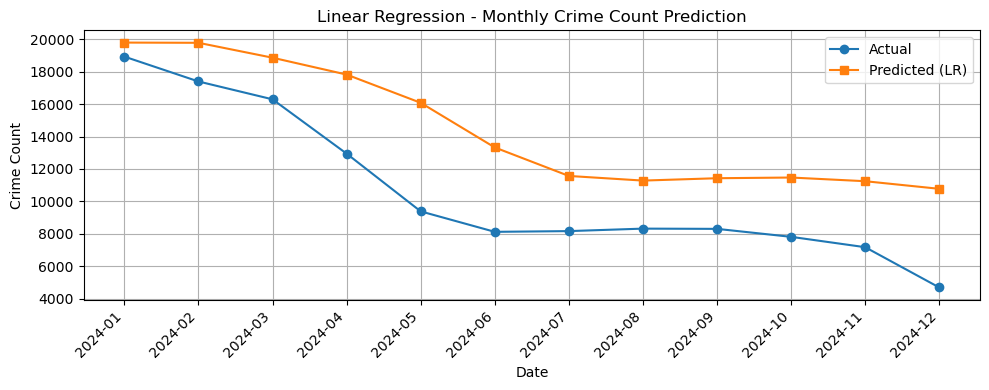

In [62]:
# Visualize the actual vs. predicted crime counts for Linear Regression
x_str = test_ml.index.astype(str)

plt.figure(figsize=(10,4))
plt.plot(x_str, y_test_ml, label='Actual', marker='o')
plt.plot(x_str, y_pred_lr, label='Predicted (LR)', marker='s')

plt.xticks(rotation=45, ha='right')
plt.title("Linear Regression - Monthly Crime Count Prediction")
plt.xlabel("Date")
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [63]:
# 1. make a Series for the predictions
pred_series = pd.Series(y_pred_lr, index=y_test_ml.index, name='predict')

# 2. rename your test-series
actual_series = y_test_ml.rename('actual')

# 3. concatenate into one DataFrame
lr_result_df = pd.concat([actual_series, pred_series], axis=1)

# 4. show difference
lr_result_df['difference'] = abs(lr_result_df['predict'] - lr_result_df['actual'])

lr_result_df.head()

,actual,predict,difference
date,,,
2024-01,18927,19792.716870,865.716870
2024-02,17395,19778.913222,2383.913222
2024-03,16294,18859.908240,2565.908240
2024-04,12946,17820.126487,4874.126487
2024-05,9387,16079.645714,6692.645714


### Random Forest

In [64]:
# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_ml, y_train_ml)

RandomForestRegressor(random_state=42)

In [65]:
# Predict the crime counts on the test set
y_pred_rf = rf_model.predict(X_test_ml)

In [66]:
# Calculate evaluation metrics
mae_rf = mean_absolute_error(y_test_ml, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_ml, y_pred_rf))
r2_rf = r2_score(y_test_ml, y_pred_rf)
mape_rf = np.mean(np.abs((y_test_ml - y_pred_rf) / y_test_ml)) * 100
print(f"[Random Forest] MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, r2: {r2_rf: .2f}, mape_lr: {mape_rf: .2f}")
metrics['Random Forest'] = [mae_rf, rmse_rf, r2_rf, mape_rf]

[Random Forest] MAE: 6436.24, RMSE: 7347.56, r2: -1.80, mape_lr:  85.00


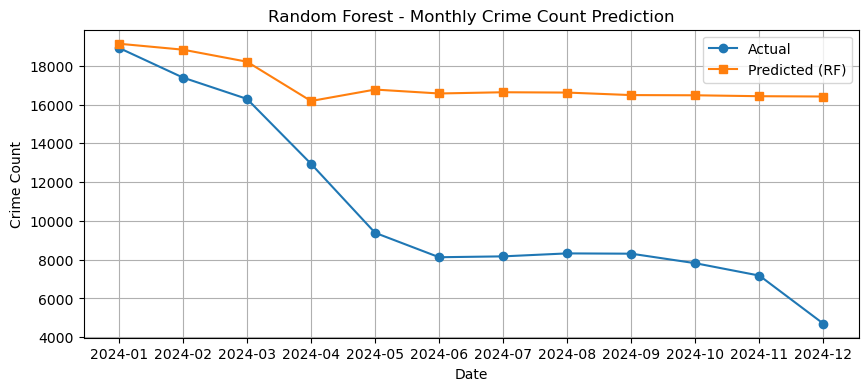

In [67]:
# Visualize the actual vs. predicted crime counts for Random Forest
x_str = test_ml.index.astype(str)

plt.figure(figsize=(10, 4))
plt.plot(x_str, y_test_ml, label='Actual', marker='o')
plt.plot(x_str, y_pred_rf, label='Predicted (RF)', marker='s')
plt.title("Random Forest - Monthly Crime Count Prediction")
plt.xlabel("Date")
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True)
plt.show()

In [68]:
# 1. make a Series for the predictions
pred_series = pd.Series(y_pred_rf, index=y_test_ml.index, name='predict')

# 2. rename your test-series
actual_series = y_test_ml.rename('actual')

# 3. concatenate into one DataFrame
rf_result_df = pd.concat([actual_series, pred_series], axis=1)

# 4. show difference
rf_result_df['difference'] = abs(lr_result_df['predict'] - lr_result_df['actual'])

rf_result_df.head()

,actual,predict,difference
date,,,
2024-01,18927,19141.09,865.716870
2024-02,17395,18834.27,2383.913222
2024-03,16294,18212.70,2565.908240
2024-04,12946,16186.07,4874.126487
2024-05,9387,16776.32,6692.645714


### SARIMAX

In [69]:
# Work directly with the original monthly_data (time series) without manual lag features.
sarimax_df = monthly_agg_crime_df.copy().dropna()

In [70]:
# Split the time series into training and testing sets (last 12 months as test)
train_sarimax = sarimax_df.iloc[:-12]
test_sarimax = sarimax_df.iloc[-12:]

In [71]:
# Parameter selection for SARIMAX
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]  # seasonal period of 12 (months)

best_aic = np.inf
best_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train_sarimax['crime_count'], 
                            order=param, 
                            seasonal_order=param_seasonal,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (param, param_seasonal)
        except Exception as e:
            continue

print(f"Best SARIMAX parameters: {best_params}, AIC: {best_aic}")

C:\Users\ZYR\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\ZYR\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ZYR\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\ZYR\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likeli

Best SARIMAX parameters: ((1, 1, 1), (1, 1, 1, 12)), AIC: 326.6765009287566


In [72]:
# Train the final SARIMAX model using the best parameters found
sarimax_model = SARIMAX(train_sarimax['crime_count'], 
                        order=best_params[0], 
                        seasonal_order=best_params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)
sarimax_res = sarimax_model.fit(disp=False)
print(sarimax_res.summary())

C:\Users\ZYR\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                        crime_count   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -158.338
Date:                            Thu, 24 Apr 2025   AIC                            326.677
Time:                                    15:58:52   BIC                            331.899
Sample:                                01-31-2020   HQIC                           327.810
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0043      0.044    -22.871      0.000      -1.090      -0.918
ma.L1          0.9993      0.484   

In [73]:
# Forecast for the test period (last 12 months)
forecast_steps = len(test_sarimax)
sarimax_forecast = sarimax_res.get_forecast(steps=forecast_steps)
sarimax_pred = sarimax_forecast.predicted_mean
sarimax_pred.index = test_sarimax.index

In [74]:
# Evaluate SARIMAX predictions
mae_sarimax = mean_absolute_error(test_sarimax['crime_count'], sarimax_pred)
rmse_sarimax = np.sqrt(mean_squared_error(test_sarimax['crime_count'], sarimax_pred))
r2_sarimax = r2_score(y_test_ml, sarimax_pred)
mape_sarimax = np.mean(np.abs((y_test_ml - sarimax_pred) / y_test_ml)) * 100
print(f"[SARIMAX] MAE: {mae_sarimax:.2f}, RMSE: {rmse_sarimax:.2f}, r2: {r2_sarimax: .2f}, mape_lr: {mape_sarimax: .2f}")
metrics['SARIMAX'] = [mae_sarimax, rmse_sarimax, r2_sarimax, mape_sarimax]

[SARIMAX] MAE: 9905.56, RMSE: 11013.33, r2: -5.28, mape_lr:  127.46


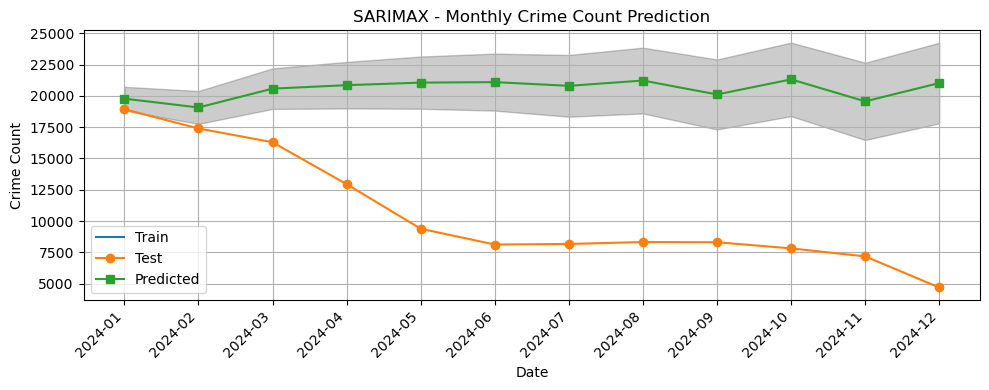

In [75]:
# Plot actual vs. predicted for SARIMAX model

# 1. Define the cutoff: keep only 2024 and later
start_period = pd.Period('2024-01', freq='M')

# 2. Filter each series/DataFrame to include only periods
train_f = train_sarimax[train_sarimax.index >= start_period]
test_f  = test_sarimax[test_sarimax.index   >= start_period]
pred_f  = sarimax_pred[sarimax_pred.index     >= start_period]
ci      = sarimax_forecast.conf_int()
ci_f    = ci[ci.index                          >= start_period]

# 3. Convert the filtered indices to strings ('YYYY-MM')
x_train = train_f.index.astype(str)
x_test  = test_f.index.astype(str)
x_pred  = pred_f.index.astype(str)
x_ci    = ci_f.index.astype(str)

# 4. Extract corresponding y values
y_train = train_f['crime_count']
y_test  = test_f['crime_count']
y_pred  = pred_f                      # if sarimax_pred is a Series

# 5. Plot train, test, and forecast from 2025 onwards
plt.figure(figsize=(10, 4))
plt.plot(x_train, y_train, label='Train')                          # training data
plt.plot(x_test,  y_test,  label='Test',    marker='o')           # test data
plt.plot(x_pred,  y_pred,  label='Predicted', marker='s')         # forecast

# 6. Fill between the lower/upper bounds of the confidence interval
plt.fill_between(
    x_ci,
    ci_f.iloc[:, 0],
    ci_f.iloc[:, 1],
    color='k',
    alpha=0.2
)

# 7. Labels, title, legend, and grid (same formatting as before)
plt.title("SARIMAX - Monthly Crime Count Prediction")
plt.xlabel("Date")
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True)

# 8. Rotate x‑axis labels to prevent overlap
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [76]:
# 1. Build a Series for the SARIMAX predictions
pred_series = pd.Series(
    data=pred_f.values,
    index=pred_f.index,
    name='predict'
)

# 2. Rename the actual test series
actual_series = test_f['crime_count'].rename('actual')

# 3. Concatenate into one DataFrame
df_sarimax = pd.concat([actual_series, pred_series], axis=1)

# 4. The index as strings 'YYYY-MM':
df_sarimax.index = df_sarimax.index.astype(str)

# 5. Calculate the difference
df_sarimax['difference'] = abs(df_sarimax['predict'] - df_sarimax['actual'])

# 6. Inspect
df_sarimax

,actual,predict,difference
date,,,
2024-01,18927,19774.458685,847.458685
2024-02,17395,19069.786946,1674.786946
2024-03,16294,20574.331490,4280.331490
2024-04,12946,20850.483235,7904.483235
2024-05,9387,21055.077090,11668.077090
2024-06,8126,21094.958989,12968.958989
2024-07,8171,20798.405145,12627.405145
2024-08,8324,21220.553201,12896.553201
2024-09,8309,20109.031640,11800.031640


# Summary

In [6]:
# Define metrics for each model
metrics_dict = {
    'Linear Regression': [3822.70, 4139.24, 0.11, 46.22],
    'Random Forest':     [6436.24, 7347.56, -1.80, 85.00],
    'SARIMAX':           [9905.56, 11013.33, -5.28, 127.46]
}

# Build DataFrame
df = pd.DataFrame(metrics_dict, index=['MAE', 'RMSE', 'R2', 'MAPE']).T

# Display the table
df

,MAE,RMSE,R2,MAPE
Linear Regression,3822.70,4139.24,0.11,46.22
Random Forest,6436.24,7347.56,-1.80,85.00
SARIMAX,9905.56,11013.33,-5.28,127.46


For forecasting monthly crime counts on this dataset, linear regression outperforms random forest based on MAE and RMSE. This suggests that the underlying patterns in the data are better captured by a linear model, making it the preferred choice among the tested models for this specific prediction task.

Although more complex machine learning models like random forest are capable of modeling non-linear relationships, in this case, the simpler linear regression model is more effective. This may indicate that the relationship in the aggregated monthly crime data is relatively linear or that the feature engineering (e.g., lag and time features) already captures most of the predictive patterns.

# Dimensionality Reduction Techniques

Dimensionality reduction methods only useful when working with dozens or hundreds of correlated features. Since my current models only use a handful of time‐based predictors (lag_1, lag_2, lag_3, year, month), there isn’t enough high‐dimensional structure for PCA or similar techniques to meaningfully improve performance.